Disclaimer: This notebook is based on the Graph Classification example notebook available at: https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

# Import Pytorch Geometric

In [15]:
!pip install -q torch-geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html


# Graph Classification with Graph Neural Networks

Aim: **Build a Graph Neural Network (GNNs) to perform graph classification**.


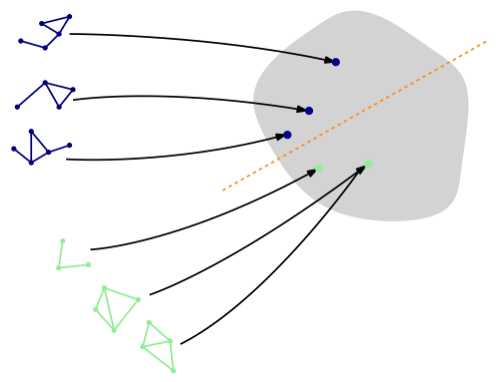

**Molecular property prediction** is a common task for graph classification. Molecules are represented as graphs, and the task is to infer the effect of the molecule.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are available via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.

This exercise uses the **MUTAG dataset**:

In [16]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


This dataset has **188 different graphs (1 graph per molecule)**, and the task is to classify each graph into **one out of two classes**.


In [ ]:
dataset

MUTAG(188)

In [ ]:
dataset[10]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

In [4]:
dataset[10].x

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

In [3]:
dataset[10].edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
         14,  7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13,  8, 12,  7, 15, 16,
         14, 14]])

In [ ]:
dataset[10].edge_attr

In [9]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


## Batching

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [10]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(batch=[1188], edge_attr=[2636, 4], edge_index=[2, 2636], ptr=[65], x=[1188, 7], y=[64])

Step 2:
Number of graphs in the current batch: 64
Batch(batch=[1139], edge_attr=[2506, 4], edge_index=[2, 2506], ptr=[65], x=[1139, 7], y=[64])

Step 3:
Number of graphs in the current batch: 22
Batch(batch=[387], edge_attr=[852, 4], edge_index=[2, 852], ptr=[23], x=[387, 7], y=[22])



## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 006, Train Acc: 0.7000, Test Acc: 0.7895
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7067, Test Acc: 0.7895
Epoch: 009, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 010, Train Acc: 0.7067, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.8158
Epoch: 012, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 014, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 016, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 018, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 019, Train Acc: 0.7267, Test Acc: 0.8421
Epoch: 020, Train Acc: 0.7467, Test Acc: 0.7895
Epoch: 021, Train Acc: 0.7600, Test Acc: